# Maîtriser les expressions régulières

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/04b_regex_TP.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/04b_regex_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/04b_regex_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/manipulation%2004b_regex_TP.ipynb%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=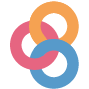" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/04b_regex_TP.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/04b_regex_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

Ce TD est directement issu du contenu de [Xavier Dupré](http://www.xavierdupre.fr/app/teachpyx/helpsphinx/c_regex/regex.html),
l’ancien professeur de ce cours. Il sera mis-à-jour dans le futur.

Chercher un mot dans un texte est une tâche facile, c’est l’objectif de la méthode `find()` attachée aux chaînes de caractères, étudiée dans la partie webscraping. Elle suffit également lorsque l’on cherche un mot au pluriel ou au singulier, mais il faut dans ce cas l’appeler au moins deux fois.

Pour des expressions plus compliquées, il est conseillé d’utiliser les expressions régulières, ou “regex”. C’est une fonctionnalité qu’on retrouve dans beaucoup de langages. C’est une forme de grammaire qui permet de rechercher des expressions.

Par exemple, lorsqu’on remplit un formulaire, on voit souvent le format `"MM/JJ/AAAA"` qui précise sous quelle forme on s’attend à ce qu’une date soit écrite. Les expressions régulières permettent de définir également ce format et de chercher dans un texte toutes les chaînes de caractères qui sont conformes à ce format.

La liste qui suit contient des dates de naissance. On cherche à obtenir toutes les dates de cet exemple sachant que les jours ou les mois contiennent un ou deux chiffres, et les années deux ou quatre.

In [2]:
s = """date 0 : 14/9/2000
date 1 : 20/04/1971     date 2 : 14/09/1913     date 3 : 2/3/1978
date 4 : 1/7/1986     date 5 : 7/3/47     date 6 : 15/10/1914
date 7 : 08/03/1941     date 8 : 8/1/1980     date 9 : 30/6/1976"""
print(s)

date 0 : 14/9/2000
date 1 : 20/04/1971     date 2 : 14/09/1913     date 3 : 2/3/1978
date 4 : 1/7/1986     date 5 : 7/3/47     date 6 : 15/10/1914
date 7 : 08/03/1941     date 8 : 8/1/1980     date 9 : 30/6/1976

#### Exemple introductif : Format de date

Le premier chiffre du `jour` est soit 0, 1, 2, ou 3 ; ceci se traduit par `[0-3]`.

Le second chiffre est compris entre 0 et 9, soit `[0-9]`. Le format des jours est traduit par `[0-3][0-9]`. Mais le premier chiffre du jour est facultatif, ce qu’on précise avec le symbole ? : `[0-3]?[0-9]`.

Les `mois` suivent le même principe : `[0-1]?[0-9]`.

Pour les `années`, ce sont les deux premiers chiffres qui sont facultatifs, le symbole ? s’appliquent alors sur les deux premiers chiffres : `[0-2]?[0-9]?[0-9][0-9]`. Le format final d’une date devient alors :

`[0-3]?[0-9]/[0-1]?[0-9]/[0-2]?[0-9]?[0-9][0-9]`

Le module `re` gère les expressions régulières, celui-ci traite différemment les parties de l’expression régulière qui sont entre parenthèses de celles qui ne le sont pas : c’est un moyen de dire au module `re` que nous nous intéressons à telle partie de l’expression qui est signalée entre parenthèses. Comme la partie qui nous intéresse - une date - concerne l’intégralité de l’expression régulière, il faut insérer celle-ci intégralement entre parenthèses.

La première étape consiste à construire l’expression régulière, la seconde à rechercher toutes les fois qu’un morceau de la chaîne `s` définie plus haut correspond à l’expression régulière.

In [3]:
import re
# première étape : construction
expression = re.compile("([0-3]?[0-9]/[0-1]?[0-9]/[0-2]?[0-9]?[0-9][0-9])")
# seconde étape : recherche
res = expression.findall(s)
print(res)

['14/9/2000', '20/04/1971', '14/09/1913', '2/3/1978', '1/7/1986', '7/3/47', '15/10/1914', '08/03/1941', '8/1/1980', '30/6/1976']

Le résultat est une liste dont chaque élément correspond aux parties comprises entre parenthèses qu’on appelle des groupes.

Lorsque les expressions régulières sont utilisées, on doit d’abord se demander comment définir ce qu’on cherche puis quelles fonctions utiliser pour obtenir les résultats de cette recherche. Les deux paragraphes qui suivent y répondent.

## Syntaxe

La syntaxe des expressions régulières est décrite sur le site officiel de python. La page [Regular Expression Syntax](https://docs.python.org/3/library/re.html) décrit comment se servir des expressions régulières, les deux pages sont en anglais. Comme toute grammaire, celle des expressions régulières est susceptible d’évoluer au fur et à mesure des versions du langage python.

## Les ensembles de caractères

Lors d’une recherche, on s’intéresse aux caractères et souvent aux classes de caractères : on cherche un chiffre, une lettre, un caractère dans un ensemble précis ou un caractère qui n’appartient pas à un ensemble précis. Certains ensembles sont prédéfinis, d’autres doivent être définis à l’aide de crochets.

Pour définir un ensemble de caractères, il faut écrire cet ensemble entre crochets. Par exemple, `[0123456789]` désigne un chiffre. Comme c’est une séquence de caractères consécutifs, on peut résumer cette écriture en `[0-9]`. Pour inclure les symboles `+` et `-`, il suffit d’écrire : `[-0-9+]`. La subtilité est qu’il faut penser à mettre le symbole `-` au début pour éviter qu’il ne désigne une séquence.

Le caractère `^` inséré au début du groupe signifie que le caractère cherché ne doit pas être un de ceux qui suivent. Le tableau suivant décrit les ensembles prédéfinis et leur équivalent en terme d’ensemble de caractères :

-   `.` désigne tout caractère non spécial quel qu’il soit.
-   `\d` désigne tout chiffre, est équivalent à `[0-9]`.
-   `\D` désigne tout caractère différent d’un chiffre, est équivalent à `[^0-9]`.
-   `\s` désigne tout espace ou caractère approché, est équivalent à `[\; \t\n\r\f\v]`. Ces caractères sont spéciaux, les plus utilisés sont `\t` qui est une tabulation, `\n` qui est une fin de ligne et qui `\r` qui est un retour à la ligne.
-   `\S` désigne tout caractère différent d’un espace, est équivalent à `[^ \t\n\r\f\v]`.
-   `\w` désigne toute lettre ou tout chiffre, est équivalent à `[a-zA-Z0-9_]`.
-   `\W` désigne tout caractère différent d’une lettre ou d’un chiffre, est équivalent à `[^a-zA-Z0-9_]`.
-   `^` désigne le début d’un mot sauf s’il est placé entre crochets.
-   `$` désigne la fin d’un mot sauf s’il est placé entre crochets.

A l’instar des chaînes de caractères, comme le caractère `\` est un caractère spécial, il faut le doubler : `[\\]`.

## Les multiplicateurs

Les multiplicateurs permettent de définir des expressions régulières comme : un mot entre six et huit lettres qu’on écrira `[\w]{6,8}`. Le tableau suivant donne la liste des multiplicateurs principaux :

-   `*` présence de l’ensemble de caractères qui précède entre 0 fois et l’infini
-   `+` présence de l’ensemble de caractères qui précède entre 1 fois et l’infini
-   `?` présence de l’ensemble de caractères qui précède entre 0 et 1 fois
-   `{m,n}` présence de l’ensemble de caractères qui précède entre *m* et *n* fois, si *m=n*, cette expression peut être résumée par `{n}`.
-   `(?!(...))` absence du groupe désigné par les points de suspensions.

L’algorithme des expressions régulières essaye toujours de faire correspondre le plus grand morceau à l’expression régulière.

Par exemple, pour la chaîne de charactère `<h1>mot</h1>`, l’expression régulière `<.*>` correspond à trois morceaux :
\* `<h1>`
\* `</h1>`
\* `<h1>mot</h1>` =\> le plus grand qui sera choisi.

Pour choisir les plus petits, il faudra écrire les multiplicateurs comme ceci : `*?`, `+?`

In [4]:
import re
import re
s = "<h1>mot</h1>"
print(re.compile("<.*>").findall(s))
print(re.compile("<.*?>").findall(s))



print(re.compile("(<.*>)").match(s).groups())

['<h1>mot</h1>']
['<h1>', '</h1>']
('<h1>mot</h1>',)

In [5]:
print(re.compile("(.*</h1>)").match(s))

<re.Match object; span=(0, 12), match='<h1>mot</h1>'>

In [6]:
print(re.compile(".*(<.h1>)").match(s).groups()) 
print(re.compile("(<.?h1>)").findall(s))

('</h1>',)
['<h1>', '</h1>']

Un exemple pour trouver des adresses emails :

In [7]:
text_emails = 'Hello from shubhamg199630@gmail.com to priya@yahoo.com about the meeting @2PM'

In [8]:
# \S` désigne tout caractère différent d'un espace 
# `+` présence de l'ensemble de caractères qui précède entre 1 fois et l'infini
liste_emails = re.findall('\S+@\S+', text_emails)     

In [9]:
print(liste_emails)

['shubhamg199630@gmail.com', 'priya@yahoo.com']

## Exercices

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 1: Application directe**

Recherchez les dates présentes dans la phrase suivante.

In [10]:
texte1 = """Je suis né le 28/12/1903 et je suis mort le 08/02/1957. Ma seconde femme est morte le 10/11/1963. 
J'ai écrit un livre intitulé 'Comprendre les fractions : les exemples en page 12/46/83' """

Puis dans celle-ci :

In [11]:
texte2 = """Je suis né le 28/12/1903 et je suis mort le 08/02/1957. Je me suis marié le 8/5/45. 
J'ai écrit un livre intitulé 'Comprendre les fractions : les exemples en page 12/46/83' """

In [12]:
# Correction
import re
expression = re.compile("([0-3]?[0-9]/[0-1]?[0-9]/[0-2]?[0-9]?[0-9][0-9])")
print(expression.findall(texte1))
print(expression.findall(texte2))

['28/12/1903', '08/02/1957', '10/11/1963']
['28/12/1903', '08/02/1957', '8/5/45']

{{% /box %}}

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 2: Nettoyer une colonne de date de publication**

L’objectif général de l’exercice est de nettoyer des colonnes d’un DataFrame en utilisant des expressions régulières.

La base en question contient des livres de la British Library et quelques informations les concernant. Le jeu de données est disponible ici : https://raw.githubusercontent.com/realpython/python-data-cleaning/master/Datasets/BL-Flickr-Images-Book.csv

La colonne “Date de Publication” n’est pas toujours une année, il y a parfois d’autres informations. Le but de l’exercice est d’avoir **une date de publication du livre propre** et de regarder la **distribution des années de publications**.

Pour ce faire, vous pouvez :
\* Soit choisir de réaliser l’exercice sans aide. Votre **lecture de l’énoncé s’arrête donc ici**. Vous devez alors faire attention à bien regarder vous-même la base de données et la transformer avec attention.

-   Soit suivre les différentes étapes qui suivent pas à pas.

In [13]:
import pandas

data_books = pandas.read_csv('https://raw.githubusercontent.com/realpython/python-data-cleaning/master/Datasets/BL-Flickr-Images-Book.csv',sep=',')

In [14]:
data_books=data_books[['Identifier', 'Place of Publication',
       'Date of Publication', 'Publisher', 'Title', 'Author']]

En regardant la base, on réalise que cette colonne ne correspond pas toujours à une année, par exemple en lignes 13 et 16.

In [15]:
data_books[['Date of Publication',"Title"]].iloc[13:20]

,Date of Publication,Title
13,"1839, 38-54",De Aardbol. Magazijn van hedendaagsche land- e...
14,1897,Cronache Savonesi dal 1500 al 1570 ... Accresc...
15,1865,"See-Saw; a novel ... Edited [or rather, writte..."
16,1860-63,"Géodésie d'une partie de la Haute Éthiopie,..."
17,1873,[With eleven maps.]
18,1866,"[Historia geográfica, civil y politica de la ..."
19,1899,"The Crisis of the Revolution, being the story ..."


1.  Commencez par regarder le nombre d’informations manquantes. On ne pourra pas avoir mieux après la regex, et normalement on ne devrait pas avoir moins…

In [16]:
data_books['Date of Publication'].isna().sum()

181

1.  Déterminer la forme de la regex pour une date de publication. A priori, il y a 4 chiffres qui forment une année.

In [17]:
import re
expression = "([0-2][0-9][0-9][0-9])"

1.  Quelles lignes sont changées quand on applique notre regex à la colonne qui nous intéresse avec la fonction `str.extract()` ?

In [18]:
data_books['Date of Publication 2'] = data_books['Date of Publication'].str.extract(expression, expand=False)
data_books[~(data_books['Date of Publication'] == data_books['Date of Publication 2'])][['Date of Publication', 'Date of Publication 2']]

,Date of Publication,Date of Publication 2
0,1879 [1878],1879
7,NaN,NaN
13,"1839, 38-54",1839
16,1860-63,1860
23,"1847, 48 [1846-48]",1847
...,...,...
8278,"1883, [1884]",1883
8279,1898-1912,1898
8283,"1831, 32",1831
8284,[1806]-22,1806


1.  On a 2 `NaN` qui n’étaient pas présents au début de l’exercice. Quels sont-ils et pourquoi ?

In [19]:
# Il s'agit de lignes qui ne contenaient pas de chaînes de caractères qui ressemblaient à des années.
data_books[~data_books['Date of Publication'].isna() & data_books['Date of Publication 2'].isna()][['Date of Publication', 'Date of Publication 2']]

,Date of Publication,Date of Publication 2
1081,112. G. & W. B. Whittaker,NaN
7391,17 vols. University Press,NaN


1.  Quelle est la répartition des dates de publications dans le jeu de données ? Vous pouvez par exemple afficher un histogramme.

<AxesSubplot:ylabel='Frequency'>

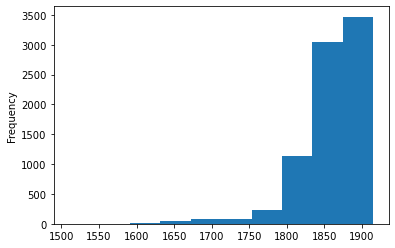

In [20]:
pandas.to_numeric(data_books['Date of Publication 2'], downcast='integer').plot(kind ="hist")

{{% /box %}}

## Aller plus loin pour apprendre les regex

-   Le site [regex101](https://regex101.com/) permet de tester les expressions régulières utilisées tout en ayant une explication qui accompagne ce test

-   De même pour [ce site](https://ole.michelsen.dk/tools/regex/) qui comporte une cheat sheet en bas de la page.

-   Les jeux de [Regex Crossword](https://regexcrossword.com/) permettent d’apprendre les expressions régulières en s’amusant